# Lagrangian Neural Networks

In this tutorial we take a look at **Lagrangian Nets** (LNNs) first proposed in [Lutter M., et al, 2019](https://arxiv.org/abs/1907.04490) and generalized by [Cranmer M., et al., 2020](https://arxiv.org/abs/2003.04630). Together with HNNs [Greydanus S., et al., 2019](https://arxiv.org/abs/1906.01563), LNNs represent the latest learning paradigm to discover symmetries and conservation laws from data.

Let $\mathcal{Q}\subset\mathbb{R}^n$ be a smooth manifold anf let $q\in\mathcal{Q}$ be a vector of generalized coordinates. The Lagrangian function $\mathcal{L}:\mathcal{TQ}\rightarrow\mathbb{R}$ is defined on the tangent bundle $\mathcal{TQ}$ of the configuration manifold $\mathcal{Q}$ (if $\mathcal{Q}=\mathbb{R}^n$, then $\mathcal{TQ}$ is diffeomorphic to $\mathbb{R}^{2n}$), i.e. the Lagrangian is a function of the configurations $q$ and their velocities $\dot q$.

Derived from the calculus of variations, the Euler-Lagrange equations of motions can be generally explicitly written as a second-order ordinary differential equation:

$$
    \ddot q = \left(\nabla_{\dot q} \nabla_{\dot q}^\top \mathcal{L}\right)^{-1}\left[\nabla_q\mathcal{L} - \left(\nabla_q\nabla^\top_{\dot q}\mathcal L\right)\dot q\right]
$$

**Lagrangian Neural Networks** try to mimick Euler-Lagrange equations by learning from data a Lagrangian $\mathcal{L}_\theta$ parametriezed by a *neural network* (with parameters $\theta$). 

When a net of tuples $\{(q_k,\dot q_k, \ddot q_k)\}_{k=1,\dots,K}$ generated by some conservative dynamical process is available, LNNs are trained to learn the Lagrangian from the data by minimizing, e.g. the *MSE loss*:
$$
    \min_{\theta}\frac{1}{K}\sum_{k=1}^K\left\|\ddot q_k - \left(\nabla_{\dot q} \nabla_{\dot q}^\top \mathcal{L}_\theta(q_k, \dot q_k)\right)^{-1}\left[\nabla_q\mathcal{L}_\theta(q_k, \dot q_k) - \left(\nabla_q\nabla^\top_{\dot q}\mathcal L_\theta(q_k, \dot q_k)\right)\dot q_k\right]\right\|_2^2
$$


We hereby showcase the torchdyn implementation of LNNs.

In [34]:
import sys
sys.path.append('../')
from torchdyn.models import *; from torchdyn.datasets import *
from torchdyn import *

The vector field of an LNN, to be passed to a `NeuralDE` can be defined as:

In [35]:
from torch.autograd import grad

class LNN(nn.Module):
    def __init__(self, L):
        super().__init__()   
        self.L = L
        
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2 
            qqd = x.requires_grad_(True)
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0] ;
            DL_q, DL_qd = J[:,:n], J[:,n:]
            DDL_qd = []
            for i in range(n):
                J_qd_i = DL_qd[:,i][:,None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:])
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T)
        return torch.cat([qqd[:,self.n:], qdd], 1)
    
    def _lagrangian(self, qqd):
        return self.L(qqd)

We consider a 1D mass-spring system

$$
    m\ddot x + kx = 0,~~~[x(0),\dot x(0)]\sim \mathcal N(0,I)
$$

Following the LNN paper from Cranmer et al., we generate random values of $x,\dot x$ and we fit (in a static manner) the corresponding $\ddot q$.

## "Static" Training

In [36]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

m, k, l = 1, 1, 1
X = torch.Tensor(2**14, 2).uniform_(-1, 1).to(device)
Xdd = -k*X[:,0]/m

train = data.TensorDataset(X, Xdd)
trainloader = data.DataLoader(train, batch_size=64, shuffle=False)

In [37]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model.defunc(0, x)
    
    def loss(self, y_hat, y):
        return ((y - y_hat[:,1])**2).mean()
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model.defunc(0, x) #static training: we do not solve the ODE 
        loss = self.loss(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.1)

    def train_dataloader(self):
        return trainloader

In [38]:
hdim = 128
net = LNN(nn.Sequential(
            nn.Linear(2,hdim),
            nn.Softplus(),
            nn.Linear(hdim,hdim),
            nn.Softplus(),
            nn.Linear(hdim,1))
         ).to(device)

model = NeuralDE(func=net, solver='dopri5').to(device)

In [39]:
model.defunc.m.L(torch.randn(10, 2).to(device))

tensor([[-0.5889],
        [-0.6804],
        [-0.5092],
        [-0.5659],
        [-0.5140],
        [-0.5851],
        [-0.6745],
        [-0.5286],
        [-0.6281],
        [-0.5539]], device='cuda:0', grad_fn=<AddmmBackward>)

In [40]:
learn = Learner(model)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 17 K  


1

In [41]:
# Evaluate the training results
import time
t = time.time()
model.nfe = 0
X0 = torch.Tensor(256, 2).uniform_(-1,1).to(device)
s_span = torch.linspace(0, 1, 100)
traj = model.trajectory(X0, s_span).cpu().detach()
T = time.time() - t
print(f"NFE: {model.nfe}\ninference time: {T}\navg time per function evaluation: {T/model.nfe}")

NFE: 26
inference time: 0.24779725074768066
avg time per function evaluation: 0.00953066349029541


Text(0.5, 1.0, "LNN's learned trajectories")

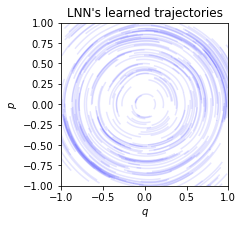

In [42]:
# Plot the LNN's trajectories with random ICs
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
color = ['orange', 'blue']
for i in range(len(X0)):
    ax.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=0.1);
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("LNN's learned trajectories")

Text(0.5, 1.0, 'Learned Lagrangian & Vector Field')

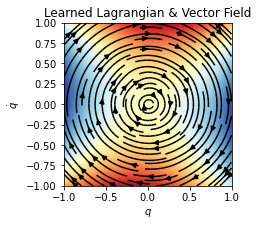

In [43]:
# Plot Lagrangian and learned vector field
n_grid =  50 ; x = torch.linspace(-1, 1, n_grid)
Q, Qd = torch.meshgrid(x, x); qqd = torch.cat([Q.reshape(-1,1), Qd.reshape(-1,1)], 1).to(device)
L = model.defunc.m.L(qqd).detach().cpu().reshape(n_grid, n_grid)
UV = model.defunc(0, qqd).detach().cpu() 
U = UV[:,0].reshape(n_grid, n_grid) ; V = UV[:,1].reshape(n_grid, n_grid)
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.contourf(Q, Qd, L,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),Qd.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([Qd.min(),Qd.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$\dot q$")
ax.set_title("Learned Lagrangian & Vector Field")

## Forced Lagrangian

Can we easily extend the framework to the non-conservative case where some forcing term is present?

Yes of course!

We can add a learnable forcinf term $f(q,\dot q)$ to the system obtaining:

$$
    \ddot q = \left(\nabla_{\dot q} \nabla_{\dot q}^\top \mathcal{L}\right)^{-1}\left[\nabla_q\mathcal{L} - \left(\nabla_q\nabla^\top_{\dot q}\mathcal L\right)\dot q + f(q, \dot q)\right]
$$


In [53]:
class fLNN(nn.Module):
    def __init__(self, L, f):
        super().__init__()   
        self.L, self.f = L, f
        
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2 
            qqd = x.requires_grad_(True)
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0] ;
            DL_q, DL_qd = J[:,:n], J[:,n:]
            DDL_qd = []
            for i in range(n):
                J_qd_i = DL_qd[:,i][:,None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:])
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T - self.f(qqd))
        return torch.cat([qqd[:,self.n:], qdd], 1)
    
    def _lagrangian(self, qqd):
        return self.L(qqd)

We now consider, e.g., a 1D mass-spring-damper system 

$$
    m\ddot x + kx + b\dot x = 0,~~~[x(0),\dot x(0)]\sim \mathcal N(0,I)
$$

and we let $q=x$, $p=\dot x$. We then train the neural network on random generated data

In [54]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

m, k, b = 1, 1, 1
X = torch.Tensor(2**15, 2).uniform_(-1, 1).to(device)
Xdd = -k*X[:,0]/m - b*X[:,1]/m
train = data.TensorDataset(X, Xdd)
trainloader = data.DataLoader(train, batch_size=128, shuffle=False)

In [55]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model.defunc(0, x)
    
    def loss(self, y_hat, y):
        return ((y - y_hat[:,1])**2).mean()
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model.defunc(0, x)
        loss = self.loss(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [56]:
hdim = 128
L = nn.Sequential(
            nn.Linear(2, hdim),
            nn.Softplus(),
            nn.Linear(hdim, hdim),
            nn.Softplus(),
            nn.Linear(hdim, 1)).to(device)

f = nn.Sequential(
            nn.Linear(2, hdim),
            nn.Softplus(),
            nn.Linear(hdim, 1)).to(device)
net = fLNN(L, f)
model = NeuralDE(func=net, solver='dopri5').to(device)

In [57]:
model.defunc.m.L(torch.randn(10, 2).to(device))

tensor([[0.0826],
        [0.1565],
        [0.1255],
        [0.0984],
        [0.0628],
        [0.1137],
        [0.1329],
        [0.0053],
        [0.1822],
        [0.1047]], device='cuda:0', grad_fn=<AddmmBackward>)

In [58]:
learn = Learner(model)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 17 K  


1

In [59]:
# Evaluate the training results
import time
t = time.time()
model.nfe = 0
X0 = torch.Tensor(64, 2).uniform_(-1,1).to(device)
s_span = torch.linspace(0, 1, 20)
traj = model.trajectory(X0, s_span).cpu().detach()
T = time.time() - t
print(f"NFE: {model.nfe}\ninference time: {T}\navg time per function evaluation: {T/model.nfe}")

NFE: 20
inference time: 0.142103910446167
avg time per function evaluation: 0.007105195522308349


Text(0.5, 1.0, "LNN's learned trajectories")

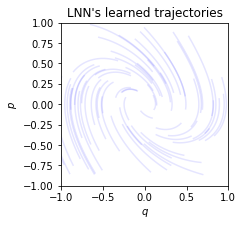

In [60]:
# Plot the forced LNN's trajectories with random ICs
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
color = ['orange', 'blue']
for i in range(len(X0)):
    ax.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=0.1);
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("LNN's learned trajectories")

Text(0.5, 1.0, 'Learned Lagrangian & Vector Field')

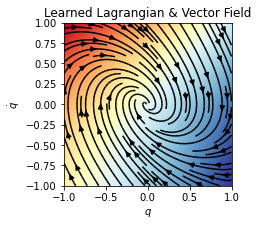

In [62]:
# Plot Lagrangian and learned vector field
n_grid =  50 ; x = torch.linspace(-1, 1, n_grid)
Q, Qd = torch.meshgrid(x, x); qqd = torch.cat([Q.reshape(-1,1), Qd.reshape(-1,1)], 1).to(device)
L = model.defunc.m.L(qqd).detach().cpu().reshape(n_grid, n_grid)
UV = model.defunc(0, qqd).detach().cpu() 
U = UV[:,0].reshape(n_grid, n_grid) ; V = UV[:,1].reshape(n_grid, n_grid)
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.contourf(Q, Qd, L,100,cmap='RdYlBu')
ax.streamplot(Q.T.numpy(),Qd.T.numpy(),U.T.numpy(),V.T.numpy(), color='black')
ax.set_xlim([Q.min(),Q.max()])
ax.set_ylim([Qd.min(),Qd.max()])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$\dot q$")
ax.set_title("Learned Lagrangian & Vector Field")